# Kogito Benchmart Report

In [24]:
import json
import csv

batch=json.load(open('test-run/batch.json'))
# print(batch)

results=[]
counter=0
for test in batch['Tests']:
    # print(test)
    csvName='test-run/results/res'+str(counter)+'.csv'
    result = pd.read_csv(csvName, header=0, index_col=False)
    # print(result)
    resultData={}
    resultData['#Replicas']=test['replicas']
    resultData['#Users']=test['users']
    resultData['MRT(ms)']=result.Average[0]
    resultData['RPS']=result.Throughput[0]
    # print(resultData)
    results.append(resultData)
    counter=counter+1

print(results)

{'Infra': {'Mongo': 'yes', 'PostgresQL': 'yes', 'DataIndex': 'no', 'Kafka': 'no'}, 'Tester': 'LOCAL', 'App': 'LOCAL', 'Process': {'schema': 'http', 'url': 'localhost', 'port': 8080, 'app': 'simpleHT'}, 'Warmup': {'enabled': 'yes', 'users': 10, 'duration': 1}, 'Tests': [{'replicas': 1, 'users': 1, 'requests': 2}, {'replicas': 1, 'users': 1, 'requests': 4}]}
{'#Replicas': 1, '#Users': 1, 'MRT(ms)': 32, 'RPS': 30.3}
{'#Replicas': 1, '#Users': 1, 'MRT(ms)': 30, 'RPS': 32.3}
[{'#Replicas': 1, '#Users': 1, 'MRT(ms)': 32, 'RPS': 30.3}, {'#Replicas': 1, '#Users': 1, 'MRT(ms)': 30, 'RPS': 32.3}]


In [1]:
import configparser
config=configparser.ConfigParser()
config.read('execution.properties')
env=config['ENV']

from IPython.display import display, Markdown
display(Markdown("| Target   |      Specs      |\n"+
    "|----------|:-------------|\n"+
    f"| Execution time |  {env['time']}|\n"+
    f"| Deployment |  {env['deployment']}|\n"+
    f"| Test Client |  {env['deployment.test']}|\n"+
    f"| Test Service |  {env['deployment.server']}|\n"+
    f"| Kogito version |  {env['kogito.version']}|\n"+
    f"| JDK version |  {env['jdk.version']}|\n"+
    f"| Duration in minutes of each test |  {env['duration.minutes']}|\n"+
    f"| Test engine |  {env['test.engine']}|"))


| Target   |      Specs      |
|----------|:-------------|
| Execution time |  Fri 15 Oct 2021 11:30:36 CEST|
| Deployment |  Cloud|
| Test Client |  appeng-vm01.cloud.lab.eng.bos.redhat.com|
| Test Service |  process-quarkus-example-fsi-kogito-benchmarking.apps.mw-ocp4.cloud.lab.eng.bos.redhat.com|
| Kogito version |  1.11.0.Final|
| JDK version |  openjdk 11.0.12 2021-07-20 LTS|
| Duration in minutes of each test |  2|
| Test engine |  JMeter|

## Execution Report
### Chart view

In [2]:
import pandas as pd
raw = pd.read_csv("rawdata.csv", names=['#Replicas','#Users','MRT(ms)','RPS'], header=0, index_col=False)

In [3]:
mrt = {}
for r in raw['#Replicas'].unique():
    mrtValues = raw[raw['#Replicas']==r]['MRT(ms)'].values
    mrt['MRT#'+str(r)] = mrtValues
# print(mrt)

In [4]:
users = raw['#Users'].unique()
# print(users)

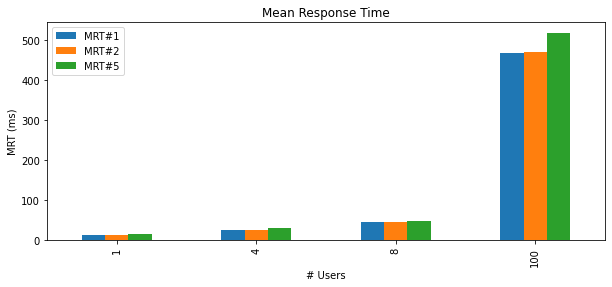

In [5]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,4)

mrtDF = pd.DataFrame(mrt
                   , index=users)

mrtDF.plot(kind="bar")
plt.title("Mean Response Time")
plt.xlabel("# Users")
plt.ylabel("MRT (ms)")
plt.rcParams["figure.figsize"] = (10,4)


In [6]:
rps = {}
for r in raw['#Replicas'].unique():
    rpsValues = raw[raw['#Replicas']==r]['RPS'].values
    rps['RPS#'+str(r)] = rpsValues

Text(0, 0.5, 'RPS')

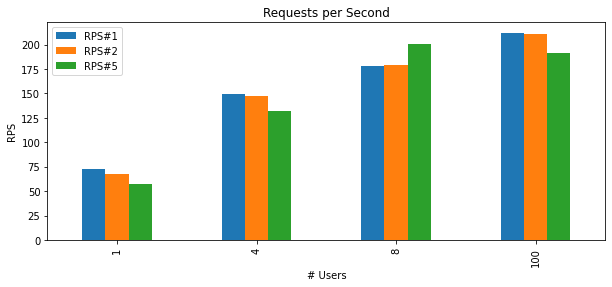

In [7]:
mrtDF = pd.DataFrame(rps
                   , index=users)

mrtDF.plot(kind="bar")
plt.title("Requests per Second")
plt.xlabel("# Users")
plt.ylabel("RPS")

### Tabular view

In [8]:
raw.style.hide_index()

#Replicas,#Users,MRT(ms),RPS
1,1,13,73
2,1,13,68
5,1,16,57
1,4,26,149
2,4,26,147
5,4,29,132
1,8,44,178
2,8,44,179
5,8,48,201
1,100,469,212
